In [31]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
import pandas as pd
from scipy import signal,interpolate
import os
import shutil

import wfdb

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [32]:
# 定义求RR间期的函数
def RR(signal,fs=250):
    rr = [] #用来存储RR间期的数组
    R_pot = [] #用来存储满足条件R点的数组
    for index,value in enumerate(signal):
        if(index>0):
            rr_pot = (value-signal[index-1])/fs
            #去除异常的RR间期数值，保留[0.3,1.5]区间的数值
            if(rr_pot < 1.5 and rr_pot >0.3):
                rr.append(rr_pot)
                R_pot.append(value)
    return rr,R_pot
# 线性内插函数
# def Interplt(signal):
#     new_signal = [signal[0]] #用来存储插值后的信号
#     for index,value in enumerate(signal):
#         if(index>0):
#             new_pot = (value+signal[index-1])/2
#             new_signal.extend([new_pot,value])
#     return new_signal
def Interplt(rr, R_pot,fs=250):            
    x = np.array(R_pot)/fs
    y = rr
    tck = interpolate.splrep(x, y, s=0)
    t = 8*60
    xnew = np.arange(0,t,0.5)
    ynew = interpolate.splev(xnew, tck, der=0)
    return xnew,ynew
# 快速傅里叶变换FFT
def FFT(signal,Fs):

    axis_t=range(len(signal))
    y=signal

    n = len(y)                  # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T                   # two sides frequency range
    frq1 = frq[range(int(n/2))] # one side frequency range

    YY = np.fft.fft(y)          # 未归一化
    Y = np.fft.fft(y)/n         # fft computing and normalization 归一化
    Y1 = Y[range(int(n/2))]

    fig, ax = plt.subplots(4, 1)

    ax[0].plot(axis_t,y)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')

    YY[0] = 0
    Y[0] = 0
    Y1[0] = 0

    ax[1].plot(frq, abs(YY),'r') # plotting the spectrum
    ax[1].set_xlabel('Freq (Hz)')
    ax[1].set_ylabel('|Y(freq)|')

    ax[2].plot(frq, abs(Y),'G')  # plotting the spectrum
    ax[2].set_xlabel('Freq (Hz)')
    ax[2].set_ylabel('|Y(freq)|')

    ax[3].plot(frq1, abs(Y1),'B') # plotting the spectrum
    ax[3].set_xlabel('Freq (Hz)')
    ax[3].set_ylabel('|Y(freq)|')
    return frq1

# butter带通滤波
def butter_bandpass(data, fre, lowcut, highcut, order=3):
    nyq = 0.5 * fre
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    new_sig = signal.filtfilt(b, a, data)
    return new_sig
# butter高通滤波
def butter_highpass(data, lowcut, fre, order=3):
    nyq = 0.5 * fre
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype="high")
    new_sig = signal.filtfilt(b, a, data)
    return new_sig
# butter低通滤波
def butter_lowpass(data, highcut, fre, order=3):
    nyq = 0.5 * fre
    high = highcut / nyq
    b, a = signal.butter(order, high, btype="low")
    new_sig = signal.filtfilt(b, a, data)
    return new_sig

In [33]:
class HMM:
    def __init__(self,A,B,pi):
        self.A =A
        self.B =B
        self.pi =pi

    # 前向算法
    def _forward(self,obs_seq):
            # 取A = N x N
            N = self.A.shape[0]
            T = len(obs_seq)

            F = np.zeros((N,T))

            # alpha = pi*b
            F[:,0] = self.pi *self.B[:,obs_seq[0]]

            for t in range(1,T):
                for n in range(N):
                    # 计算第t时，第n个状态的前向概率
                    F[n,t] = np.dot(F[:,t-1], (self.A[:,n])) * self.B[n, obs_seq[t]]
            return F
# 调用：
# h = HMM(A,B,pi)
# # 人为定义的海藻状态序列
# obs_seq = ('dry','damp','soggy')
# obs_seq_index = convert_observations_to_index(obs_seq,observations_label_index)

# # 计算P(o|lambda)
# F = h._forward(obs_seq_index)
# print ("forward: P(O|lambda) = %f" %sum(F[:,-1]))

    # 后向算法
    def _backward(self,obs_seq):
            N = self.A.shape[0]
            T = len(obs_seq)

            X = np.zeros((N,T))
            # 表示X矩阵的最后一列
            X[:,-1:] =1

            for t in reversed(range(T-1)):
                for n in range(N):
                    # 边权值为a_ji
                    X[n,t] = sum(X[:,t+1] * self.A[n,:] * self.B[:,obs_seq[t+1]])

            return X
        
    #     baum_welch_train算法
    def baum_welch_train(self, observations, criterion=0.05):
        n_states = self.A.shape[0]
        # 观察序列的长度T
        n_samples = len(observations)

        done = False
        while not done:
            # alpha_t(i) = P(o_1,o_2,...,o_t,q_t = s_i | hmm)
            # Initialize alpha
            # 获得所有前向传播节点值 alpha_t(i)
            alpha = self._forward(observations)

            # beta_t(i) = P(o_t+1,o_t+2,...,o_T | q_t = s_i , hmm)
            # Initialize beta
            # 获得所有后向传播节点值 beta_t(i)
            beta = self._backward(observations)

            # 计算 xi_t(i,j) -> xi(i,j,t)
            xi = np.zeros((n_states, n_states, n_samples - 1))
            # 在每个时刻
            for t in range(n_samples - 1):
                # 计算P(O | hmm)
                denom = sum(alpha[:, -1])
                for i in range(n_states):
                    # numer[1,:] = 行向量，alpha[i,t]=实数，slef.A[i,:] = 行向量
                    # self.B[:,observations[t+1]].T = 行向量,beta[:,t+1].T = 行向量
                    numer = alpha[i, t] * self.A[i, :] * self.B[:, observations[t + 1]].T * beta[:, t + 1].T
                    xi[i, :, t] = numer / denom

                # 计算gamma_t(i) 就是对j进行求和
                gamma = np.sum(xi, axis=1)
                # need final gamma elements for new B
                prod = (alpha[:, n_samples - 1] * beta[:, n_samples - 1]).reshape((-1, 1))
                # 合并T时刻的节点
                gamma = np.hstack((gamma, prod / np.sum(prod)))
                # 列向量
                newpi = gamma[:, 0]
                newA = np.sum(xi, 2) / np.sum(gamma[:, :-1], axis=1).reshape((-1, 1))
                newB = np.copy(self.B)

                # 观测状态数
                num_levels = self.B.shape[1]
                sumgamma = np.sum(gamma, axis=1)
                for lev in range(num_levels):
                    mask = observations == lev
                    newB[:, lev] = np.sum(gamma[:, mask], axis=1) / sumgamma

                if np.max(abs(self.pi - newpi)) < criterion and \
                                np.max(abs(self.A - newA)) < criterion and \
                                np.max(abs(self.B - newB)) < criterion:
                    done = 1
                self.A[:], self.B[:], self.pi[:] = newA, newB, newpi
        return A,B,pi
            

In [34]:
# 将75种状态值转换为字典的键
def gengerate_index_map(labels):
    label_index = {}
    i =0
    for l in labels:
        label_index[l] =i
        i+=1
    return label_index
# 将随机观察值（键）转为观察值字典中的值（有序数组）
def convert_observations_to_index(observations,label_index):
    list =[]
    for o in observations:
        list.append(label_index[o])
    return list

In [35]:
'''
#  Download all the WFDB records and annotations from Polysomnograghic Database(slpdb)（已下载完成，先将此模块注释掉）

# Make a download directory in current working directory
cwd = os.getcwd()
dl_dir = os.path.join(cwd, 'slpdb_dl_dir')

# Download all the WFDB content
wfdb.dl_database('slpdb', dl_dir=dl_dir)

# Display the downloaded content in the folder
# display(os.listdir(dl_dir))

# Cleanup: delete the downloaded directory
# shutil.rmtree(dl_dir)
'''

"\n#  Download all the WFDB records and annotations from Polysomnograghic Database(slpdb)（已下载完成，先将此模块注释掉）\n\n# Make a download directory in current working directory\ncwd = os.getcwd()\ndl_dir = os.path.join(cwd, 'slpdb_dl_dir')\n\n# Download all the WFDB content\nwfdb.dl_database('slpdb', dl_dir=dl_dir)\n\n# Display the downloaded content in the folder\n# display(os.listdir(dl_dir))\n\n# Cleanup: delete the downloaded directory\n# shutil.rmtree(dl_dir)\n"

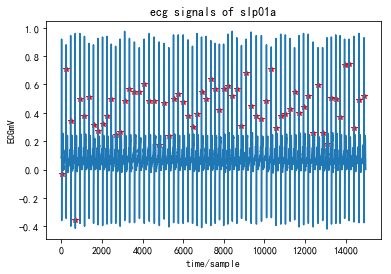

{'adc_gain': [-200.0],
 'adc_res': [12],
 'adc_zero': [0],
 'base_counter': '94',
 'base_date': '19/1/1989',
 'base_time': '23:07:00',
 'baseline': [0],
 'block_size': [0],
 'byte_offset': [None],
 'checksum': [36435],
 'comments': ['44 M 89 32-01-89'],
 'counter_freq': '0.033333333',
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal': None,
 'file_name': ['slp01a.dat'],
 'fmt': ['212'],
 'fs': 250,
 'init_value': [-17],
 'n_sig': 1,
 'p_signal': array([[ 0.085],
        [ 0.08 ],
        [ 0.125],
        ...,
        [-0.   ],
        [-0.   ],
        [-0.   ]]),
 'record_name': 'slp01a',
 'samps_per_frame': [1],
 'sig_len': 15000,
 'sig_name': ['ECG'],
 'skew': [None],
 'units': ['mV']}

{'ann_len': 3,
 'aux_note': ['4 LA LA', '4 LA', '4 LA'],
 'chan': array([0, 0, 0]),
 'contained_labels': None,
 'custom_labels': None,
 'description': None,
 'extension': 'st',
 'fs': 250,
 'label_store': None,
 'num': array([0, 0, 0]),
 'record_name': 'slp01a',
 'sample': array([    1,  7500, 15000]),
 'subtype': array([0, 0, 0]),
 'symbol': ['"', '"', '"']}

'============='

The fs of slp01a:
 250
The annotition of R on ecg sample slp01a:
 [   19   234   457   687   911  1137  1360  1581  1808  2029  2244  2460
  2673  2890  3117  3354  3599  3841  4080  4327  4576  4822  5061  5292
  5526  5761  5998  6234  6460  6682  6906  7134  7360  7578  7787  7993
  8202  8418  8643  8874  9104  9352  9606  9857 10106 10343 10577 10808
 11038 11268 11490 11710 11933 12165 12407 12647 12873 13093 13306 13520
 13736 13954 14176 14414 14664 14912]
annotition of sleep station on ecg sample slp01a:
 [    1  7500 15000]


In [36]:
# Display sample information
record = wfdb.rdrecord('slpdb_dl_dir/slp01a', channels=[0],sampto = 15000)
ann_ecg = wfdb.rdann('slpdb_dl_dir/slp01a','ecg',sampto = 15000)
ann_st = wfdb.rdann('slpdb_dl_dir/slp01a','st',sampto = 15000)

wfdb.plot_wfdb(record=record, annotation=ann_ecg, title='ecg signals of slp01a')
display(record.__dict__)
# display("=============")
# display(ann_ecg.__dict__)
# display("=============")
display(ann_st.__dict__)
display("=============")
print("The fs of slp01a:\n",record.fs)
print("The annotition of R on ecg sample slp01a:\n",ann_ecg.sample)
print("annotition of sleep station on ecg sample slp01a:\n",ann_st.sample)

Text(0.5,0,'RR intervals signal:Time(30s)')

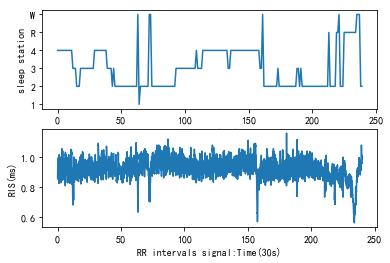

In [37]:
# 计算RR间期
record = wfdb.rdrecord('slpdb_dl_dir/slp01a', channels=[0])
ann_ecg = wfdb.rdann('slpdb_dl_dir/slp01a','ecg')
ann_st = wfdb.rdann('slpdb_dl_dir/slp01a','st')

# print(ann_st.aux_note[:10])
st = [] #用来存储睡眠状态标签的数组
for aux_note in ann_st.aux_note:
    st.append(aux_note.split(" ")[0])

rr,R_pot = RR(ann_ecg.sample)          
#Display the RR intervals and sleep staged by PhisioNet
t = record.sig_len/record.fs      #信号长度（s）  
fig, ax = plt.subplots(2, 1)
# 将MT（Moment time 运动状态替换为W）
for index, value in enumerate(st):
    if value=='MT':
        st[index]='W'
        
axis_st = [t*value/(30*len(ann_st.sample)) for value in range(0,len(ann_st.sample))]
ax[0].plot(axis_st,st)
ax[0].set_ylabel('sleep station')
ax[0].set_xlabel('页:Time(30s)')

axis_rr = [t*value/(30*len(rr)) for value in range(0,len(rr))]
ax[1].plot(axis_rr,rr)
ax[1].set_ylabel('RIS(ms)')
ax[1].set_xlabel("RR intervals signal:Time(30s)")

[64, 15, 12, 0, 213, 63]


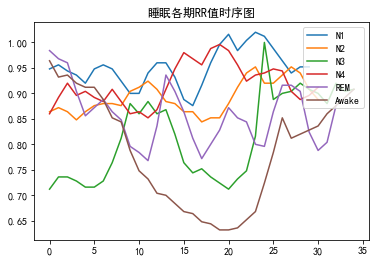

In [38]:
# 下面给出睡眠各期RR值时序图，以便观察不同睡眠分期RR间期的分布
stations = ['1','2','3','4','R','W']
stations_index = []
# 分别找出6个30s睡眠分期的索引
for station in stations:
    for index,value in enumerate(st):
        if(value == station):
            stations_index.append(index)
            break
print(stations_index)

for value in stations_index:
    sig_start = value*record.fs*30
    sig_end = (value+1)*record.fs*30
    ecg_value_index = []
    for index,value in enumerate(ann_ecg.sample):
        if(value >= sig_start and value <= sig_end):
            ecg_value_index.append(index)
    ecg_value = ann_ecg.sample[ecg_value_index[0]:ecg_value_index[-1]]
    plt.plot(RR(ecg_value)[0])
plt.legend(['N1','N2','N3','N4','REM','Awake'], loc="upper right")
plt.title("睡眠各期RR值时序图")
plt.show()

RR间期最低频率： 0.0001388888888888889
RR间期最高频率： 0.5418055555555555


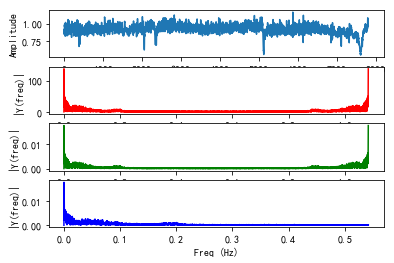

In [39]:
# FFT变换，对RR间期进行频谱分析，可以看出信号频率介于0~0.6Hz 之间
Fs = len(rr)/t             # sampling rate采样率为1（约等于）
signal = rr
fs_distribute = FFT(signal,Fs)
print('RR间期最低频率：', min(fs_distribute[1:]))
print('RR间期最高频率：',max(fs_distribute))

In [40]:
# 根据香农定理：采样频率不能低于信号最高频率的2倍，进行二次采样，采样频率2Hz
# # RR 间期时间序列事实上是一个非均匀采样序列，国内学者一般认为这种非均匀性非常小，可近似的认为该序列在时间轴上是均匀采样的
# # 原采样频率
# fs_raw = len(rr)/t
# print('RR间期原始采样频率：',fs_raw)
# fs_re = 2*fs_raw
# # 重采样方法：线性内插法进行插值
# rr_new = Interplt(rr)

# axis_rr_new = [t*value/(30*len(rr_new)) for value in range(0,len(rr_new))]
# plt.plot(axis_rr_new,rr_new)
# plt.title("RR intervals signal after re-sample:Time(30s)")
# plt.show()

# # signal = rr_new
# # fs_distribute = FFT(signal,2)
# # print('RR间期最低频率：', min(fs_distribute[1:]))
# # print('RR间期最高频率：',max(fs_distribute))

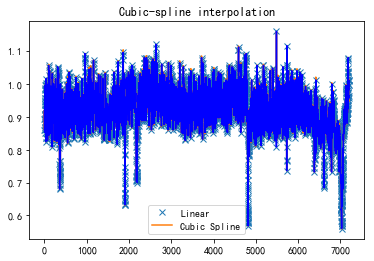

In [41]:
# 因为RR间期是一个非均匀采样序列，考虑用三次样条插值进行重采样，重采样频率为2HZ（参考庄志论文）
from scipy import interpolate

# x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
# y = np.sin(x)
x = np.array(R_pot)/record.fs
y = rr
tck = interpolate.splrep(x, y, s=0)
# xnew = np.arange(0,2*np.pi,np.pi/50)
xnew = np.arange(0,t,0.5)
ynew = interpolate.splev(xnew, tck, der=0)

plt.figure()
plt.plot(x, y, 'x', xnew, ynew, x, y, 'b')
plt.legend(['Linear', 'Cubic Spline'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')
plt.show()


In [42]:
# 将重采样的RR间期序列赋给rr_new
rr_new = ynew
axis_rr_new = xnew/30


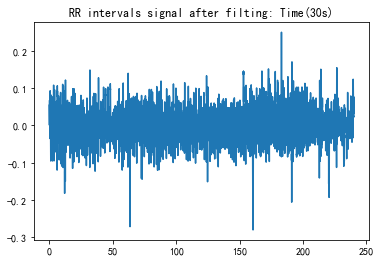

RR间期最低频率： 0.0001388888888888889
RR间期最高频率： 0.9998611111111111


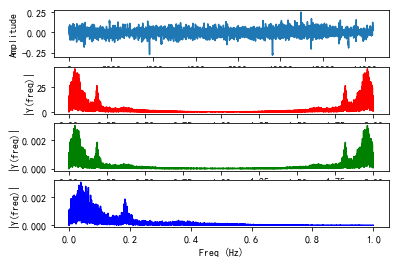

In [43]:
from scipy import signal
# # 通过Butter 高通或带通滤波器，去除直流分量和基线漂移0~0.0001Hz
# # ECG频率范围为0.05~100hz，RR间期频率在0~0.6Hz间,对比滤波效果，本次采用lowcut = 0.005 ,因为和基线漂移频率接近，易去掉有效低频部分
# # 而HRV的超低频部分（0.0033~0.04Hz）和睡眠的关系比较密切，因此本项目不采用butter滤波器
# lowcut1 = 0.005
# lowcut2 = 0.01
# highcut = 0.6
# rr_filt1 = butter_highpass(rr_new, lowcut1, fs_re, order=3)
# rr_filt2 = butter_highpass(rr_new, lowcut2, fs_re, order=3)
# # rr_filt = butter_lowpass(rr_new, highcut, fs_re, order=3)
# # rr_filt = butter_bandpass(rr_new, fs_re, lowcut, highcut, order=3)

# 中值滤波较好的去除了直流分量和基线漂移，而为去除有效低频部分
rr_filt = rr_new - signal.medfilt(rr_new,101) #中值滤波,第二个参数是邻域的大小(奇数)

plt.plot(axis_rr_new,rr_filt)
plt.title("RR intervals signal after filting: Time(30s)")
# plt.legend(['lowcut1 = 0.0005','lowcut2 = 0.01'], loc="upper right")
plt.show()

signal = rr_filt
fs_distribute = FFT(signal,2)
print('RR间期最低频率：', min(fs_distribute[1:]))
print('RR间期最高频率：',max(fs_distribute))

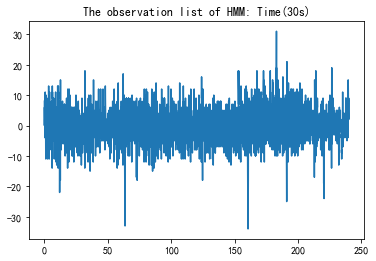

In [44]:
# 滤波后的RR间期信号rr_filt即为后面要建立的HMM的观察量，为了减少观察量的取值数目，查找（-0.3,0.3）s区间外的数组，置为-0.3/0.3，然后除以8取整
# 因此，RR间期共有[-37,37]共75种可能的取值（由RMSSD公式，HMM观察值共有[0,74]共75种取值）
# np.where(rr_filt>0.3) or np.where(rr_filt<-0.3)
hmm_obsv_rr = []
for value in rr_filt:
    if(value < -0.3):
        value = -37 #int(-0.3*1000/8)
    elif(value > 0.3):
        value = 37 #int(0.3*1000/8)
    else:
        value = int(1000*value/8)
    hmm_obsv_rr.append(value)

plt.plot(axis_rr_new,hmm_obsv_rr)
plt.title("The observation list of HMM: Time(30s)")
plt.show()


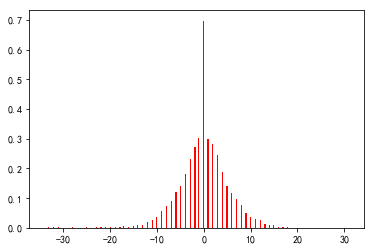

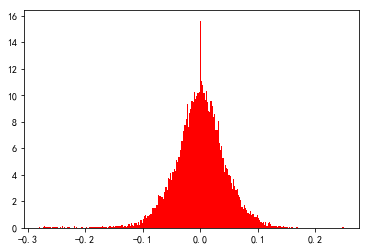

KstestResult(statistic=0.3162776458295986, pvalue=0.0)
(0.9565344452857971, 0.0)
KstestResult(statistic=0.44912381413452807, pvalue=0.0)
(0.9743260145187378, 1.5414283107572988e-44)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [45]:
from scipy.stats import kstest
from scipy import stats

plt.hist(hmm_obsv_rr, bins=256, normed=1,edgecolor='None',facecolor='red')  #画出hmm_obsv_rr的直方图
plt.show()
plt.hist(rr_filt, bins=256, normed=1,edgecolor='None',facecolor='red')  #画出hmm_obsv_rr的直方图
plt.show()
test_stat1 = kstest(hmm_obsv_rr, 'norm') #p-value=0<0.05,拒绝假设，假设不成立（hmm_obsv_rr不服从正态分布）
print(test_stat1)
print(stats.shapiro(hmm_obsv_rr))#第二个为p值，<0.5,不服从正态分布
test_stat2 = kstest(rr_filt, 'norm') #p-value=0<0.05,拒绝假设，假设不成立（rr_filt不服从正态分布）
print(test_stat2)
print(stats.shapiro(rr_filt))#第二个为p值，<0.5,不服从正态分布

In [50]:
# 为消除不同个体差异应用直方图匹配法：先寻找hmm_obsv_rr的90%有效区间[-a,a]
for a in range(37):
    count_a = 0 # 将介于区间[-a,a]的r计数，初始化为0
    for r in hmm_obsv_rr:
        if(r > -a and r < a):
            count_a += 1
    if(count_a > 0.9*len(hmm_obsv_rr)):
        choose_a = count_a
        break
print(a)# 即90%的点落在[-8,8]之间


8


In [46]:
## 预处理模块：将不同睡眠分期状态及对应的RIS观察值写进文件hmm_obsv.txt
cwd = os.getcwd()
HMM_data_path = os.path.join(cwd, 'HMM_data')
# HMM_data_path = cwd +"\\HMM_data"
folder = os.path.exists(HMM_data_path)  
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹  
    os.makedirs(HMM_data_path)            #makedirs 创建文件时如果路径不存在会创建这个路径  
    print ("---  New folder...  ---")  
    print ("---  OK  ---" ) 
else:  
    print ("---  There is this folder!  ---" ) 

file =  os.path.join(HMM_data_path, 'hmm_obsv.txt') 
# file = HMM_data_path +"\\hmm_obsv.txt"
# fid = open(file,"w")
# fid.write("Hello, world\n")

# fid.close()


---  There is this folder!  ---


In [47]:
from scipy import signal
# slp01a 共有len(st)=240个睡眠分期，因为选取的RIS序列为包含该睡眠分期的T=8min片段，因此可训练睡眠分期共有240-15=225个，即st[15:len(st)]
# 观察值序列分别为[0,8min],[0.5,8.5min],[1,9min]...共225个片段对应的经过插值滤波后的8分钟RR间期，下面给出实现代码

T = 8
fs = record.fs
min_sample = 60*fs

# fid = open(file,"w")
data_for_train = []
for st_num in range(len(st)-2*T+1):
    sig_start = 0.5*st_num*min_sample
    sig_end = (T+0.5*st_num)*min_sample
    hmm_rr_st_index = []
    for index,value in enumerate(ann_ecg.sample):
        if(value >= sig_start and value <= sig_end):
            hmm_rr_st_index.append(index)
    hmm_rr_st = ann_ecg.sample[hmm_rr_st_index[0]:hmm_rr_st_index[-1]] # 每个睡眠分期对应的T=8分钟RR间期索引序列

    # 获取RR间期序列，并重采样
    st_rr,st_R_pot = RR(hmm_rr_st,fs)

    st_R_pot = st_R_pot-st_R_pot[0]
    hmm_rr_st = Interplt(st_rr,st_R_pot)[1] #三次样条插值函数Interplt

    hmm_rr_st_num = hmm_rr_st - signal.medfilt(hmm_rr_st,101) #将滤波后的RR间期序列赋给对应睡眠分期的观测值
    hmm_obsv_rr = []
    #限幅和编码
    for value in hmm_rr_st_num:
        if(value < -0.3):
            value = -37 #int(-0.3*1000/8)
        elif(value > 0.3):
            value = 37 #int(0.3*1000/8)
        else:
            value = int(1000*value/8)
        hmm_obsv_rr.append(value)
#     # 由RMSSD公式计算T=8分钟RR间期对应的HRV
#     hmm_obsv_hrv = 0
#     for index in range(0,len(hmm_obsv_rr)-1):
#         hmm_obsv_hrv+=math.pow((hmm_obsv_rr[index+1]-hmm_obsv_rr[index]),2)
#     hmm_obsv_hrv = math.sqrt(hmm_obsv_hrv/(len(hmm_obsv_rr)-1))
        
    data_for_train.append([st[st_num+2*T-1],hmm_obsv_rr]) #将睡眠标签及对应8分钟观察值存进数组data_for_train
#     print(st[st_num+2*T-1],len(hmm_rr_st_num))
#     fid.write(st[st_num+2*T-1]+" "+str(hmm_rr_st_num)+"\n")
    
# fid.close() 
        
# np.savetxt(file, np.array(str(data_for_train)))


In [48]:
fid = open(file,"w")
# fid.write(str(data_for_train))
for line in data_for_train:
    fid.write(line[0]+",")
    for content in line[1]:
        fid.write(str(content)+",")
    fid.write("\n")
fid.close()
print(len(data_for_train))
print(data_for_train[0][0])
print(data_for_train[0][1][:10])
# for i in range(len(data_for_train)):
#     print(data_for_train[i][0])

225
2
[0, 2, 4, 7, 6, 4, 4, 3, 3, 2]


In [49]:
## 读取睡眠标签及观察值序列文件hmm_obsv.txt # np.load(file)#调用不成功
file =  os.path.join(HMM_data_path, 'hmm_obsv.txt') 
fid = open(file,"r")
note = fid.readlines()
fid.close()

states = [] # 存储hmm_obsv.txt的睡眠标签

T = 960 #设置观察序列长度T=2*60*8=960
observations_data = np.empty((len(note),T)) #用来存储观察值序列的矩阵，每行为一个观察值序列，每个序列长度固定为T=960
Ti = 0

for line in note:
    line_rr = line.split(",")
    states.append(line_rr[0])#将睡眠标签写进states数组
    line_new = [] # 对应RR间期
    for content in line_rr[1:-1]:  #去掉第一位标签，最后一位换行符
        line_new.append(int(content)) #int 的作用是将str转为int

#     print(line_rr[0])
#     print(line_new)
#     print("==================")

    # 为了保证观察序列长度一致，设置观察序列长度T=2*60*8=960，因此从序列最后开始倒数选取T个观察值
    #（why倒数选取T个观察值：因为越后面的RR间期越能反应当前的睡眠分期）
    line_new = line_new[-T:]
    observations_data[Ti:] = line_new
    Ti+=1

print(observations_data)

     

[[ 0.  2.  4. ... 10. 18. 31.]
 [ 1.  0.  0. ...  9.  3.  0.]
 [17. 12. 12. ...  0.  0.  0.]
 ...
 [ 2.  0.  0. ... 34. 37. 37.]
 [ 5.  5.  4. ...  4.  2.  0.]
 [ 9.  9.  7. ...  0.  0.  0.]]


In [ ]:
import hmmlearn

# 预处理自此结束，下面调用python库中的hmmlearn进行模型训练及预测，见sleep_hrv_model.py

In [155]:
# seterr
from numpy import seterr
np.seterr(divide='ignore',invalid='ignore')

## 给定6种睡眠分期对应的观察序列，分别利用Baum-Welch算法学习6个模型参数λi=(Ai,Bi,πi)
# 轮训1次
# 初始化
A = np.array([[0.20, 0.16, 0.16, 0.16, 0.16, 0.16],
              [0.16, 0.20, 0.16, 0.16, 0.16, 0.16],
              [0.16, 0.16, 0.20, 0.16, 0.16, 0.16],
              [0.16, 0.16, 0.16, 0.20, 0.16, 0.16],
              [0.16, 0.16, 0.16, 0.16, 0.20, 0.16],
              [0.16, 0.16, 0.16, 0.16, 0.16, 0.20]])

B_random = np.random.random((6,75))
B = np.empty((6,75))
line_i = 0
for line in B_random:
    line = line/sum(line)
    B[line_i] = line
    line_i+=1
    
pi = np.array([0.16, 0.16, 0.16, 0.16, 0.20, 0.16])
model = HMM(A,B,pi)

observations = list(range(-37,38))
observations_label_index = gengerate_index_map(observations)
print("将75种观察值及对应的位置转换为字典:\n",observations_label_index)

# for line in note:
#     line_rr = line.split(",")
#     observations_data = [] # 对应RR间期(观察值序列)
#     for content in line_rr[1:-1]:  #去掉第一位标签，最后一位换行符
#         observations_data.append(int(content)) #int 的作用是将str转为int
#     obs_seq_index = convert_observations_to_index(observations_data,observations_label_index)
#     A,B,pi = model.baum_welch_train(obs_seq_index)

observations_data = []
for content in note[0].split(",")[1:-1]: 
    observations_data.append(int(content)) #int 的作用是将str转为int
obs_seq_index = convert_observations_to_index(observations_data,observations_label_index)
A,B,pi = model.baum_welch_train(np.array(obs_seq_index)[:300])
print("hello")

将75种观察值及对应的位置转换为字典:
 {-37: 0, -36: 1, -35: 2, -34: 3, -33: 4, -32: 5, -31: 6, -30: 7, -29: 8, -28: 9, -27: 10, -26: 11, -25: 12, -24: 13, -23: 14, -22: 15, -21: 16, -20: 17, -19: 18, -18: 19, -17: 20, -16: 21, -15: 22, -14: 23, -13: 24, -12: 25, -11: 26, -10: 27, -9: 28, -8: 29, -7: 30, -6: 31, -5: 32, -4: 33, -3: 34, -2: 35, -1: 36, 0: 37, 1: 38, 2: 39, 3: 40, 4: 41, 5: 42, 6: 43, 7: 44, 8: 45, 9: 46, 10: 47, 11: 48, 12: 49, 13: 50, 14: 51, 15: 52, 16: 53, 17: 54, 18: 55, 19: 56, 20: 57, 21: 58, 22: 59, 23: 60, 24: 61, 25: 62, 26: 63, 27: 64, 28: 65, 29: 66, 30: 67, 31: 68, 32: 69, 33: 70, 34: 71, 35: 72, 36: 73, 37: 74}


KeyboardInterrupt: 

In [ ]:
'''
## 监督学习方法（因为8分钟每个RR间期对应的睡眠状态不明确，下面将8分钟都默认为一个睡眠状态，误差大，不可取，考虑非监督学习算法Baum-Welch）
# 计算初始概率start_probability
stations = ['1','2','3','4','R','W']
count_stations = np.zeros(6)
for index in range(6):
    count_stations[index]=states.count(stations[index])

print("['1','2','3','4','R','W']对应频数：",count_stations)
print("Number of count_stations: %d" % sum(count_stations))
start_probability = count_stations/sum(count_stations)
print("Start_probability:\n",start_probability)
'''

In [ ]:
'''
# 转移概率矩阵transition_probability
transition_tuple = [] #转移状态数组
for index,value in enumerate(states[1:]):
    transition_tuple.append([states[index-1],value])
# transition_tuple.count(['2', '2'])
transition_count = np.zeros((6,6))
transition_probability = np.zeros((6,6)) 
for line in range(6):
    for colum in range(6):
        transition_count[line][colum] = transition_tuple.count([stations[line], stations[colum]])
    transition_probability[line] = transition_count[line]/sum(transition_count[line])
# print("Transition_count matric:\n",transition_count)
print("Transition_probability matric :\n",transition_probability)
'''

In [ ]:
'''
# 观测（发射）概率矩阵emission_probability
observations = list(range(-37,38)) #观测值75个
emission_tuple = [] # 状态发射到观测值的存储数组

for line in note:
    line_rr = line.split(",")
    line_st = line_rr[0] # 每一行对应睡眠状态
    line_new = [] # 对应RR间期
    for content in line_rr[1:-1]:  #去掉第一位标签，最后一位换行符
        line_new.append(int(content))
        emission_tuple.append([line_st,content])

emission_count = np.zeros((6,75))
emission_probability = np.zeros((6,75))
for line in range(6):
    for colum in range(75):
#         print([stations[line],str(observations[colum])])
        emission_count[line][colum] = emission_tuple.count([stations[line],str(observations[colum])]) #str作用为将int观测值转换为str类型

    emission_probability[line] = emission_count[line]/sum(emission_count[line])
# print("Emission_count matric :\n",emission_count)
# print("Emission_probability matric :\n",emission_probability)
'''

In [ ]:
# 至此，HMM模型已搭建完毕
# 下面转换为HMM的概率计算问题：给定6个模型λi=(Ai,Bi,πi)和观测序列O={o1,o2,...,oT}，计算在模型λi下观测序列O出现的概率P(O|λi)
# 求index(max(P(O|λi))：概率最大时的模型所对应的睡眠分期，即为此观测值对应的睡眠状态
pi = start_probability
A = transition_probability
B = emission_probability
h = HMM(A,B,pi)
# 75种状态序列observations = list(range(-37,38))
obs_seq =  [1, 2, 4, 5, 7, 5, 4, 4, 4, 2]
obs_seq_index = convert_observations_to_index(obs_seq,observations_label_index)
# print("观察序列对应的数组:\n",obs_seq_index)

# 计算P(o|lambda)
F = h._forward(obs_seq_index)
print ("forward: P(O|lambda) = %f" %sum(F[:,-1]))